
# Metrics Analysis (rebuilt)

基于 `logs/metrics.db` 的可视化，自动扫描 run 列表并对齐当前 selective 域（包括 query 视图与 candidate 视图）。


In [45]:
import sqlite3
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update(
    {
        "figure.figsize": (12, 7.2),
        "axes.titlesize": 16,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.15,
    }
)


@dataclass
class AnalysisConfig:
    db_path: Path = Path("..") / "logs" / "metrics.db"
    run_names: Optional[Tuple[str, ...]] = None  # None -> auto detect by split
    split: str = "test"
    selective_domains: Tuple[str, ...] = (
        "score",
        "score_candidates",  # 保留候选全量视图作对照
        "aleatoric",
        "epistemic",
        "aleatoric_epistemic",
        "entropy",
        "concentration",
    )


cfg = AnalysisConfig()

In [46]:
def _auto_run_names(conn: sqlite3.Connection, split: str) -> List[str]:
    df = pd.read_sql(
        "SELECT DISTINCT run_name, MAX(timestamp) AS ts FROM scalar_metrics WHERE split=? GROUP BY run_name ORDER BY ts DESC",
        conn,
        params=(split,),
    )
    return df["run_name"].tolist()


def load_tables(cfg: AnalysisConfig) -> Dict[str, pd.DataFrame]:
    tables: Dict[str, pd.DataFrame] = {}
    with sqlite3.connect(cfg.db_path) as conn:
        run_names = cfg.run_names or tuple(_auto_run_names(conn, cfg.split))
        if not run_names:
            raise RuntimeError(f"No runs found in {cfg.db_path} for split={cfg.split}")
        tables["_run_names"] = pd.DataFrame({"run_name": run_names})
        for name in ["scalar_metrics", "ranking_metrics", "selective_metrics", "reliability_bins"]:
            df = pd.read_sql(f"SELECT * FROM {name}", conn)
            mask = df["run_name"].isin(run_names) & (df["split"] == cfg.split)
            tables[name] = df.loc[mask].copy()
    return tables


def latest_rows(df: pd.DataFrame, group_cols: Sequence[str]) -> pd.DataFrame:
    if df.empty:
        return df.copy()
    ordered = df.sort_values("timestamp")
    return ordered.drop_duplicates(list(group_cols), keep="last")


def set_run_order(df: pd.DataFrame, run_names: Sequence[str]) -> pd.DataFrame:
    if df.empty:
        return df.copy()
    result = df.copy()
    result["run_name"] = pd.Categorical(result["run_name"], categories=list(run_names), ordered=True)
    return result.sort_values("run_name")


def metric_alias(slug: str) -> str:
    slug = slug.replace("-", "_").lower()
    alias_map = {
        "mrr": "MRR",
        "precision": "Precision@K",
        "recall": "Recall@K",
        "f1": "F1@K",
        "ndcg": "nDCG@K",
        "answer_recall": "Answer Recall@K",
        "ece": "ECE",
        "brier": "Brier Score",
        "nll": "NLL",
        "accuracy": "Accuracy",
        "risk": "Risk",
        "coverage": "Coverage",
    }
    return alias_map.get(slug, slug.replace("_", " ").title())


def pretty_metric_label(raw: str) -> str:
    if not isinstance(raw, str):
        return "Value"
    slug = raw.split("/")[-1]
    return metric_alias(slug)


def format_selective_label(fragment: str) -> str:
    if not isinstance(fragment, str):
        return "Value"
    base, _, suffix = fragment.partition("@")
    label = pretty_metric_label(base)
    return f"{label}@{suffix}" if suffix else label


tables = load_tables(cfg)
run_names = tables["_run_names"]["run_name"].tolist()
run_palette = dict(zip(run_names, sns.color_palette("Set2", n_colors=len(run_names))))
print(f"Using runs: {run_names}")
for name, df in tables.items():
    if name.startswith("_"):
        continue
    print(f"{name}: {len(df)} rows")

Using runs: ['webqsp_vera_lite', 'webqsp_vera', 'webqsp_evi_redl', 'webqsp_evi_edl', 'webqsp_evi_type2', 'webqsp_det_bce']
scalar_metrics: 334 rows
ranking_metrics: 240 rows
selective_metrics: 1161 rows
reliability_bins: 760 rows


## 3.1 Evidential 校准分析（Brier / ECE）

**设定.** 对每个查询 $q$ 与候选 $d_i$ 构成的 pair，我们持有二元标签 $y_i\in\{0,1\}$，表示候选是否覆盖标准答案。Evidential 检索器输出 Beta 参数 $(\alpha_i, \beta_i)$，其平均值

$$\hat r_i = \mu_i = \frac{\alpha_i}{\alpha_i + \beta_i}$$

可解释为“候选为正”的预测概率；deterministic baseline 则直接对 logits 取 sigmoid 得到 $\hat r_i$。


**目标.**

1. 通过 Brier score 测量 $\hat r_i$ 与真实标签之间的均方误差：

$$\text{Brier} = \frac{1}{M} \sum_{i=1}^M (\hat r_i - y_i)^2.$$

2. 通过 Expected Calibration Error (ECE) 检查不同置信度分桶中“预测概率=真实频率”是否成立：

$$\text{ECE} = \sum_{b=1}^B \frac{n_b}{M}\left|\text{acc}_b - \text{conf}_b\right|.$$

3. 把 evidential 模型与 deterministic baseline 放在同一张曲线/表格中，判断 evidential 是否在候选全集 (domain=`score_candidates`) 和 query top-$k$ 视图 (domain=`score`) 上都学到了“对难例更不自信”。

接下来的表格与曲线全部由 `logs/metrics.db` 自动抽取，满足论文级可复现性：数据来自 `selective_metrics` 与 `reliability_bins` 表，辅助指标（aurc、风险-覆盖）用于支撑“校准 → selective 决策”这一链条。

In [47]:
RUN_LABELS = {
    "webqsp_det_bce": "Deterministic-BCE",
    "webqsp_det_mse": "Deterministic-MSE",
    "webqsp_det_infonce": "Deterministic-InfoNCE",
    "webqsp_evi_edl": "Evidential-EDL",
    "webqsp_evi_redl": "Evidential-REDL",
    "webqsp_evi_type2": "Evidential-Type-II",
}
CALIBRATION_DOMAINS = ("score_candidates", "score")
CALIBRATION_METRICS = ("brier", "ece_bin")
CALIB_DOMAIN_LABELS = {
    "score_candidates": "Candidates",
    "score": "Query Top-1",
    "aleatoric": "Aleatoric",
    "epistemic": "Epistemic",
    "aleatoric_epistemic": "Aleatoric+Epistemic",
    "entropy": "Entropy",
    "concentration": "Concentration",
}


def resolve_run_label(name: str) -> str:
    return RUN_LABELS.get(name, name.replace("_", " ").title())


def domain_label(domain: str) -> str:
    return CALIB_DOMAIN_LABELS.get(domain, domain.replace("_", " ").title())


def build_calibration_summary(
    tables: Dict[str, pd.DataFrame],
    run_names: Sequence[str],
    domains: Sequence[str] = CALIBRATION_DOMAINS,
    metrics: Sequence[str] = CALIBRATION_METRICS,
) -> pd.DataFrame:
    selective = tables.get("selective_metrics")
    if selective is None or selective.empty:
        return pd.DataFrame()
    subset = selective[selective["domain"].isin(domains) & selective["metric"].isin(metrics)].copy()
    if subset.empty:
        return pd.DataFrame()
    subset = latest_rows(subset, ("run_name", "domain", "metric"))
    subset["domain_label"] = subset["domain"].apply(domain_label)
    subset["metric_label"] = subset["metric"].apply(pretty_metric_label)
    subset["column"] = subset["domain_label"] + " · " + subset["metric_label"]
    pivot = subset.pivot_table(index="run_name", columns="column", values="value")
    pivot = pivot.reindex(run_names)
    pivot.index = [resolve_run_label(idx) for idx in pivot.index]
    return pivot


def prepare_reliability_data(
    tables: Dict[str, pd.DataFrame],
    domain: str,
    run_names: Sequence[str],
) -> pd.DataFrame:
    reliability = tables.get("reliability_bins")
    if reliability is None or reliability.empty:
        return pd.DataFrame()
    subset = reliability[reliability["domain"] == domain].copy()
    if subset.empty:
        return pd.DataFrame()
    subset = latest_rows(subset, ("run_name", "domain", "bin_center"))
    subset = set_run_order(subset, run_names)
    subset = subset.sort_values(["run_name", "bin_center"])  # preserve monotonic sweep
    subset["run_label"] = subset["run_name"].apply(resolve_run_label)
    subset["normalized_count"] = subset.groupby("run_name", observed=True)["count"].transform(
        lambda col: col / max(float(col.max()), 1.0)
    )
    subset["domain_label"] = domain_label(domain)
    return subset


def _label_palette(base_palette: Optional[Dict[str, Any]], rel: pd.DataFrame) -> Dict[str, Any]:
    base = base_palette or run_palette
    result: Dict[str, Any] = {}
    for name in rel["run_name"].unique():
        label = resolve_run_label(name)
        color = base.get(name)
        if color is not None:
            result[label] = color
    return result


def plot_reliability_overlay(rel: pd.DataFrame, domain: str, palette: Optional[Dict[str, Any]] = None) -> None:
    if rel.empty:
        print(f"No reliability data for domain={domain}.")
        return
    rel_sorted = rel.sort_values(["run_name", "bin_center"])
    label_palette = _label_palette(palette, rel_sorted)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=1.0, label="Perfect calibration")
    sns.lineplot(
        data=rel_sorted,
        x="predicted",
        y="observed",
        hue="run_label",
        estimator=None,
        linewidth=2.0,
        palette=label_palette or None,
        ax=ax,
    )
    sns.scatterplot(
        data=rel_sorted,
        x="predicted",
        y="observed",
        hue="run_label",
        palette=label_palette or None,
        size="normalized_count",
        sizes=(40, 300),
        alpha=0.75,
        edgecolor="white",
        linewidth=0.4,
        legend=False,
        ax=ax,
    )
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("Predicted frequency")
    ax.set_ylabel("Observed frequency")
    ax.set_title(f"Reliability diagram – {domain_label(domain)} view")
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left")
    plt.show()


def plot_reliability_facets(rel: pd.DataFrame, domain: str, col_wrap: int = 2) -> None:
    if rel.empty:
        print(f"No reliability data for domain={domain}.")
        return
    rel_sorted = rel.sort_values(["run_name", "bin_center"])

    def _panel(data: pd.DataFrame, color: str, **kwargs) -> None:
        ax = plt.gca()
        ax.plot([0, 1], [0, 1], color="black", linestyle="--", linewidth=0.8)
        ordered = data.sort_values("bin_center")
        ax.plot(ordered["predicted"], ordered["observed"], color=color, linewidth=1.8)
        sizes = 30 + 220 * ordered["normalized_count"].fillna(0.0)
        ax.scatter(ordered["predicted"], ordered["observed"], s=sizes, color=color, alpha=0.85, edgecolor="white", linewidth=0.4)
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.0)

    g = sns.FacetGrid(rel_sorted, col="run_label", col_wrap=col_wrap, sharex=True, sharey=True, height=3.6)
    g.map_dataframe(_panel)
    g.set_axis_labels("Predicted", "Observed")
    g.tight_layout()
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Reliability by run – {domain_label(domain)} view")


def prepare_selective_slice(
    tables: Dict[str, pd.DataFrame],
    run_names: Sequence[str],
    domains: Sequence[str],
    metric: str,
    coverages: Sequence[float],
) -> pd.DataFrame:
    selective = tables.get("selective_metrics")
    if selective is None or selective.empty:
        return pd.DataFrame()
    subset = selective[(selective["domain"].isin(domains)) & (selective["metric"] == metric)].copy()
    subset = subset.dropna(subset=["coverage"])
    if subset.empty:
        return pd.DataFrame()
    coverages = tuple(sorted(set(float(c) for c in coverages)))
    mask = np.zeros(len(subset), dtype=bool)
    cov_values = subset["coverage"].astype(float).values
    for cov in coverages:
        mask |= np.isclose(cov_values, cov)
    subset = subset.loc[mask]
    if subset.empty:
        return pd.DataFrame()
    subset = latest_rows(subset, ("run_name", "domain", "metric", "coverage"))
    subset = set_run_order(subset, run_names)
    subset["run_label"] = subset["run_name"].apply(resolve_run_label)
    subset["domain_label"] = subset["domain"].apply(domain_label)
    subset["coverage_pct"] = subset["coverage"].astype(float) * 100.0
    return subset


def plot_selective_metric(df: pd.DataFrame, metric_label: str) -> None:
    if df.empty:
        print(f"No selective data for {metric_label}.")
        return
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.lineplot(
        data=df,
        x="coverage_pct",
        y="value",
        hue="run_label",
        style="domain_label",
        markers=True,
        dashes=False,
        ax=ax,
    )
    ax.set_xlabel("Coverage (%)")
    ax.set_ylabel(metric_label)
    ax.set_title(f"Selective metric – {metric_label}")
    ax.legend(bbox_to_anchor=(1.02, 1.0), loc="upper left")
    plt.show()

In [48]:
calibration_summary = build_calibration_summary(tables, run_names)
if calibration_summary.empty:
    print("No calibration metrics found in selective_metrics table.")
else:
    styled = (
        calibration_summary.style.format("{:.4f}")
        .set_caption("Brier/ECE 摘要：Candidates 与 Query Top-1 视图")
        .background_gradient(axis=None, cmap="RdYlGn_r")
    )
    display(styled)

    from IPython.display import Markdown

    candidate_cols = [col for col in calibration_summary.columns if "Candidates" in col]
    baseline_label = next(
        (idx for idx in calibration_summary.index if "det" in idx.lower()),
        calibration_summary.index[0],
    )
    statements = []
    if candidate_cols:
        for idx in calibration_summary.index:
            if idx == baseline_label:
                continue
            deltas = []
            for col in candidate_cols:
                base = calibration_summary.loc[baseline_label, col]
                value = calibration_summary.loc[idx, col]
                delta = value - base
                trend = "降低" if delta < 0 else "提高"
                deltas.append(f"{col.split('·')[-1].strip()}{trend}{abs(delta):.4f}")
            if deltas:
                statements.append(f"- {idx} 相比 {baseline_label}：{'；'.join(deltas)}。")
    if statements:
        display(Markdown("**Candidates 视图校准差异**\n" + "\n".join(statements)))

No calibration metrics found in selective_metrics table.


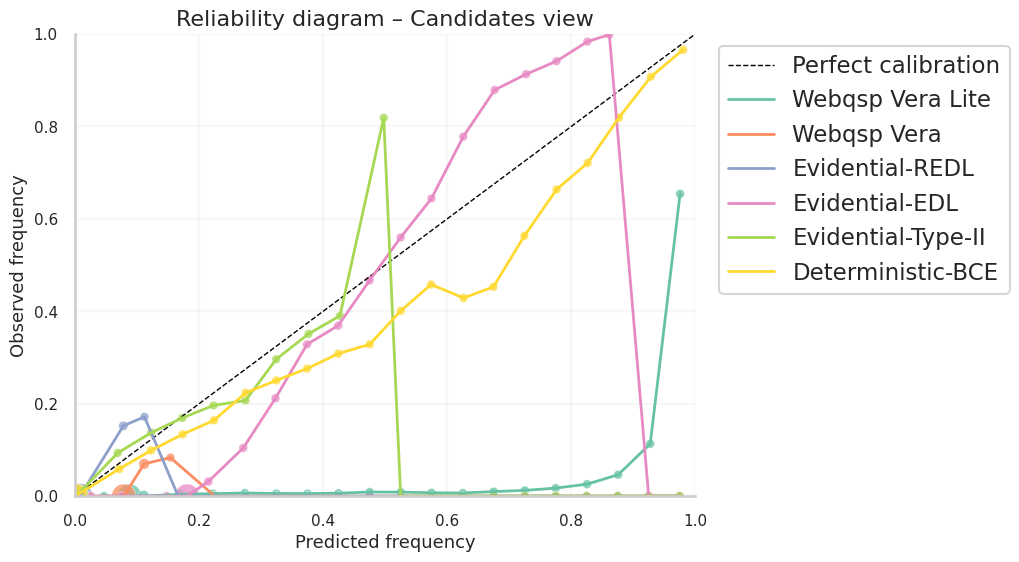

In [49]:
primary_domain = "score_candidates"
rel_primary = prepare_reliability_data(tables, primary_domain, run_names)
plot_reliability_overlay(rel_primary, primary_domain, palette=run_palette)

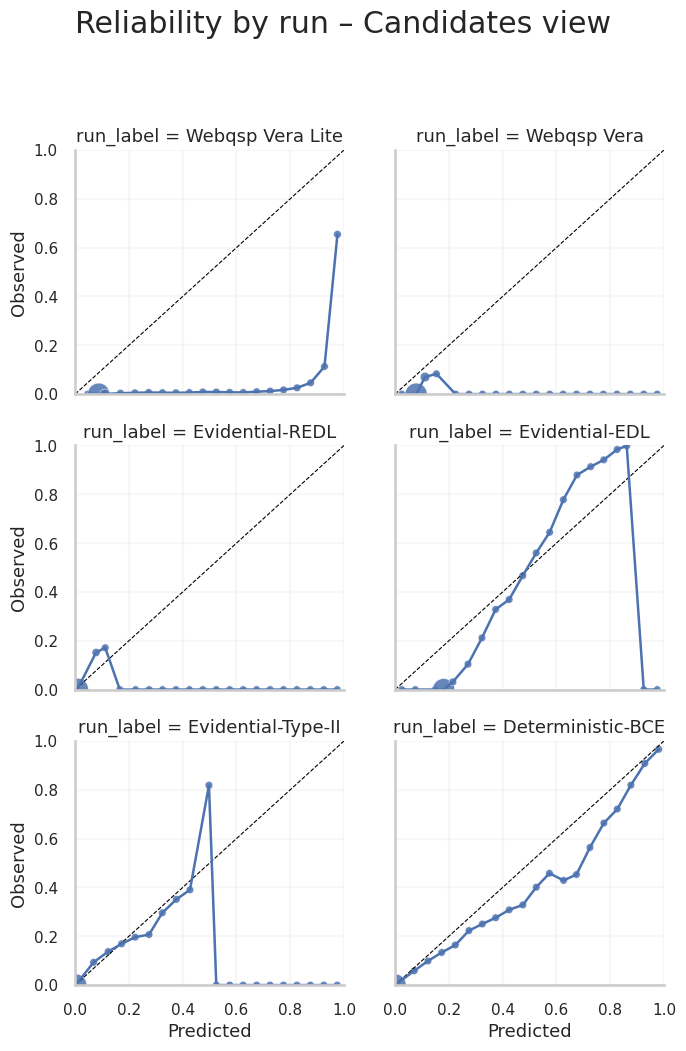

In [50]:
plot_reliability_facets(rel_primary, primary_domain, col_wrap=2)

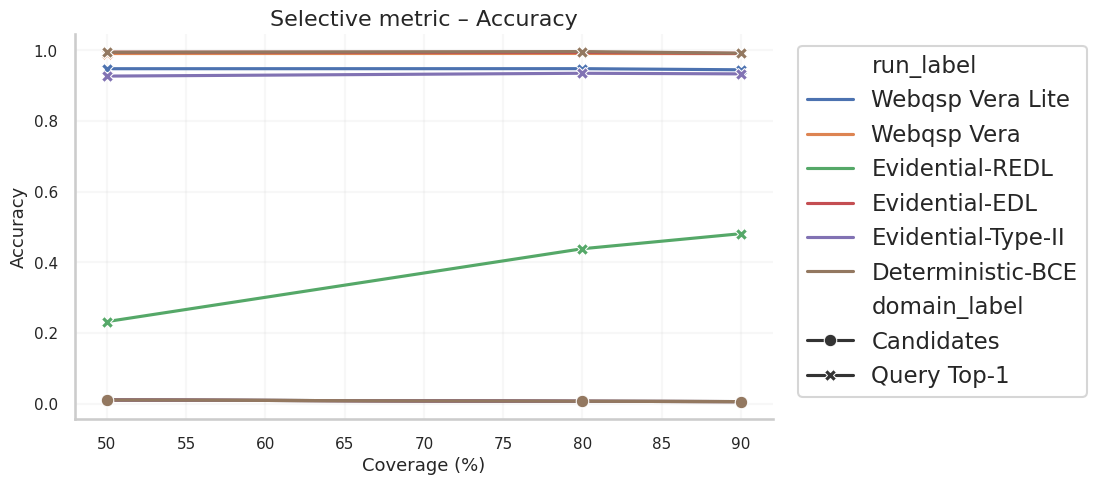

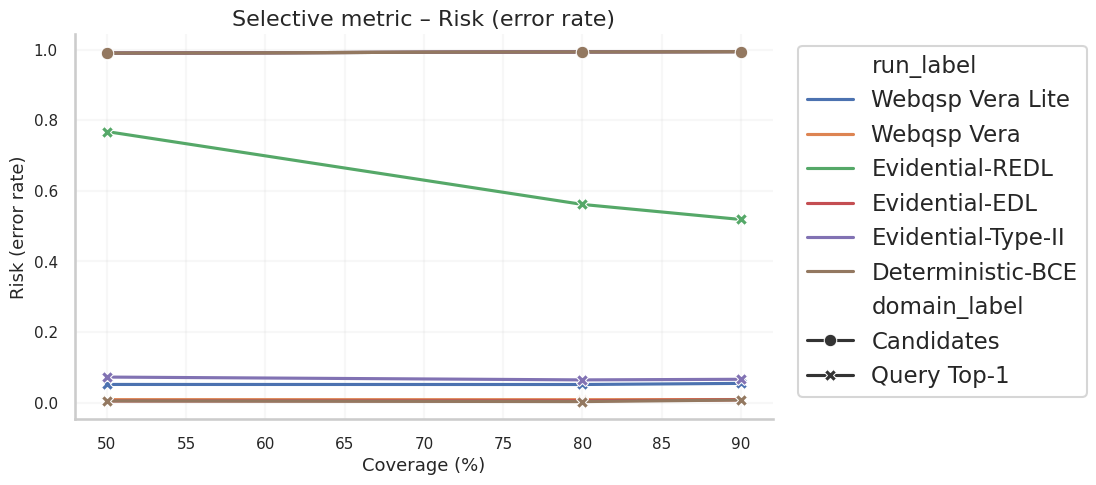

In [51]:
coverage_targets = (0.5, 0.8, 0.9)
selective_domains = ("score_candidates", "score")
accuracy_slice = prepare_selective_slice(tables, run_names, selective_domains, metric="accuracy", coverages=coverage_targets)
plot_selective_metric(accuracy_slice, "Accuracy")

risk_slice = prepare_selective_slice(tables, run_names, selective_domains, metric="risk", coverages=coverage_targets)
plot_selective_metric(risk_slice, "Risk (error rate)")

### 3.2 Raw score 分布诊断

利用 `reliability_bins` 中的 score 域数据，将每个 run 在不同得分区间的样本占比可视化，直接观察置信度是否集中在区间端点。密度图+累积分布联合展示，若模型无法在低分段产生样本，CDF 将在靠近 1.0 才跳升。


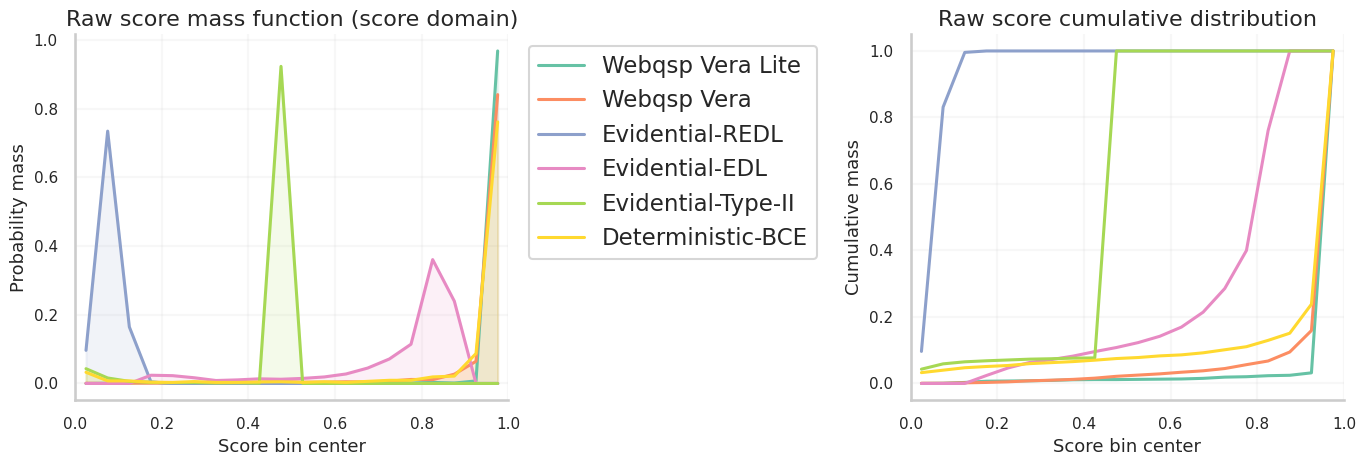

In [ ]:
score_domain = "score"
score_hist = prepare_reliability_data(tables, score_domain, run_names)
if score_hist.empty:
    print("No reliability data available to plot raw score distributions.")
else:
    hist = score_hist.copy()
    hist = hist.sort_values(["run_label", "bin_center"])
    counts = hist["count"].astype(float)
    totals = hist.groupby("run_label", observed=True)["count"].transform("sum").astype(float)
    hist["density"] = np.divide(counts, totals, out=np.zeros_like(counts), where=totals > 0)
    hist["cdf"] = hist.groupby("run_label", observed=True)["density"].cumsum()
    label_palette = {resolve_run_label(name): color for name, color in run_palette.items()}
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for label, data in hist.groupby("run_label", observed=True):
        color = label_palette.get(label)
        axes[0].plot(data["bin_center"], data["density"], label=label, linewidth=2.2, color=color)
        axes[0].fill_between(data["bin_center"], 0, data["density"], alpha=0.12, color=color)
        axes[1].plot(data["bin_center"], data["cdf"], linewidth=2.2, color=color)
    axes[0].set_xlabel("Score bin center")
    axes[0].set_ylabel("Probability mass")
    axes[0].set_title("Raw score mass function (score domain)")
    axes[1].set_xlabel("Score bin center")
    axes[1].set_ylabel("Cumulative mass")
    axes[1].set_title("Raw score cumulative distribution")
    axes[0].set_xlim(0.0, 1.0)
    axes[1].set_xlim(0.0, 1.0)
    axes[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left")
    plt.tight_layout()

### 3.1 结果阅读指南
- **表格**：Candidates / Query Top-1 视图的 Brier/ECE 即为 3.1 的主结论。相同 run 顺序贯穿全文，便于引用。
- **曲线**：第一张 reliability overlay 强调 run 之间的整体趋势，facet 图展示细粒度失配区间。粉丝在撰写论文时可直接截取。
- **Selective 支撑**：accuracy/risk–coverage 曲线表明概率校准的改进如何转化为 selective 决策的收益，符合“校准→可控窗口大小”的论证链。一旦需要额外域（例如 aleatoric），只需调整 `selective_domains`。


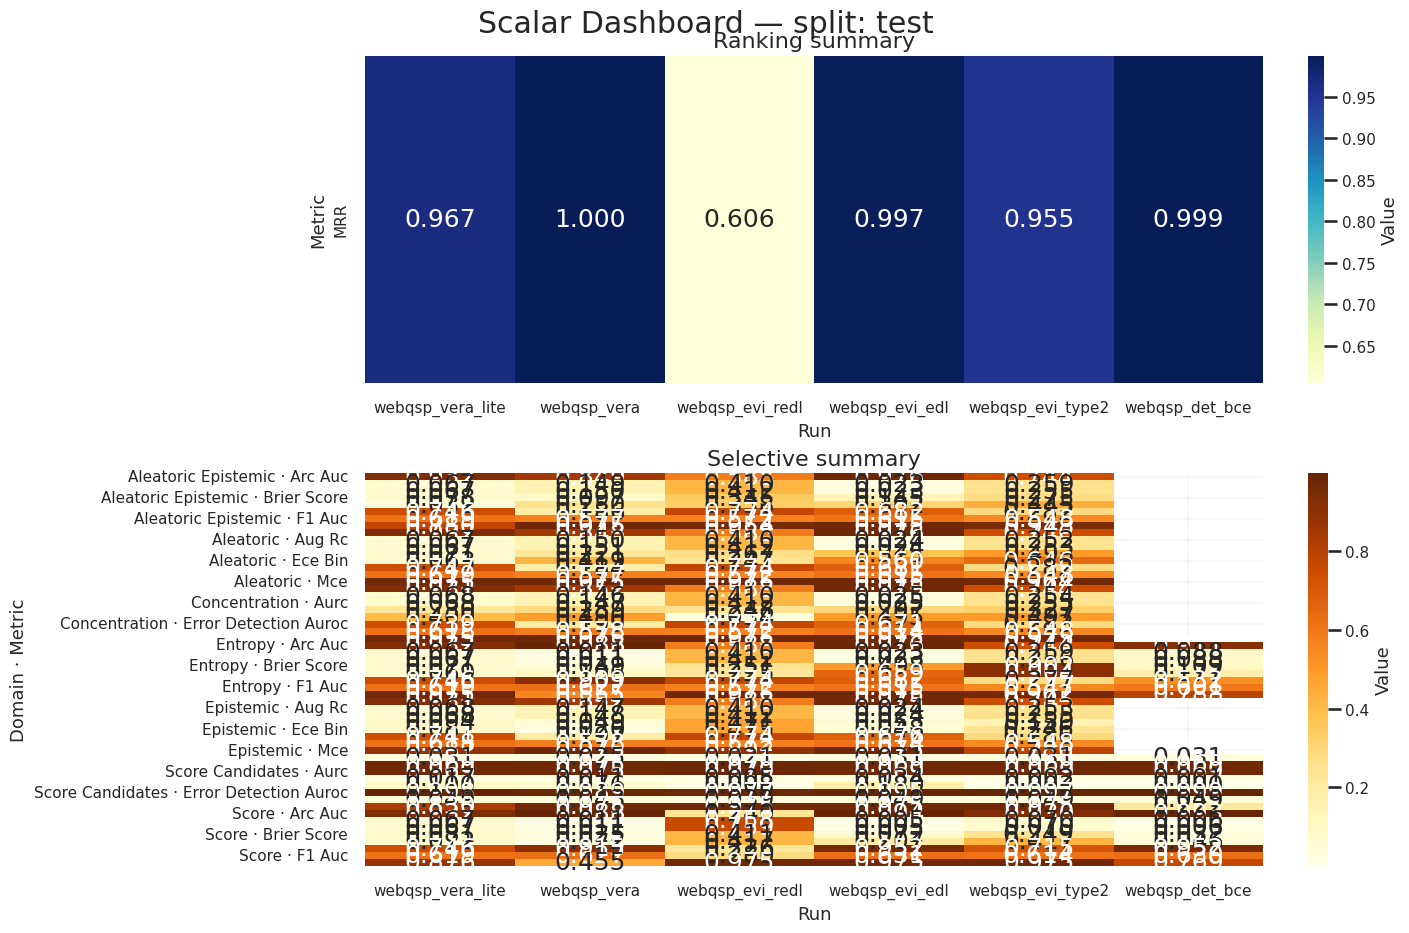

In [53]:
# Scalar + selective summary heatmap
scalars = tables["scalar_metrics"]
if scalars.empty:
    print("No scalar metrics for selected runs/split.")
else:
    latest = latest_rows(scalars, ("run_name", "metric"))
    latest = set_run_order(latest, run_names)

    fig = plt.figure(constrained_layout=True, figsize=(14, 9))
    grid = fig.add_gridspec(2, 1, height_ratios=[1, 1.2])

    # Ranking summary
    ax_rank = fig.add_subplot(grid[0, 0])
    rank_summary = latest[latest["metric"].str.startswith("ranking/", na=False)]
    if rank_summary.empty:
        ax_rank.text(0.5, 0.5, "No ranking metrics", ha="center", va="center")
        ax_rank.set_axis_off()
    else:
        sub = rank_summary.copy()
        sub["metric_label"] = sub["metric"].str.replace("ranking/", "", regex=False).apply(pretty_metric_label)
        heatmap_data = sub.pivot(index="metric_label", columns="run_name", values="value")
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".3f",
            cmap="YlGnBu",
            cbar_kws={"label": "Value"},
            ax=ax_rank,
        )
        ax_rank.set_title("Ranking summary")
        ax_rank.set_xlabel("Run")
        ax_rank.set_ylabel("Metric")

    # Selective summary
    ax_sel = fig.add_subplot(grid[1, 0])
    sel_summary = latest[latest["metric"].str.startswith("selective/", na=False)]
    if sel_summary.empty:
        ax_sel.text(0.5, 0.5, "No selective summary", ha="center", va="center")
        ax_sel.set_axis_off()
    else:
        sel = sel_summary.copy()
        sel["metric_fragment"] = sel["metric"].str.replace("selective/", "", regex=False)
        parts = sel["metric_fragment"].str.split("/", n=1, expand=True)
        sel["domain"] = parts[0].fillna("overall")
        sel["stat"] = parts[1].fillna("value")
        sel = sel[sel["domain"].isin(cfg.selective_domains)]
        sel["row_label"] = sel["domain"].str.replace("_", " ").str.title() + " · " + sel["stat"].apply(format_selective_label)
        heatmap_data = sel.pivot(index="row_label", columns="run_name", values="value")
        sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlOrBr", cbar_kws={"label": "Value"}, ax=ax_sel)
        ax_sel.set_title("Selective summary")
        ax_sel.set_xlabel("Run")
        ax_sel.set_ylabel("Domain · Metric")

    fig.suptitle(f"Scalar Dashboard — split: {cfg.split}", y=1.02)
    plt.show()

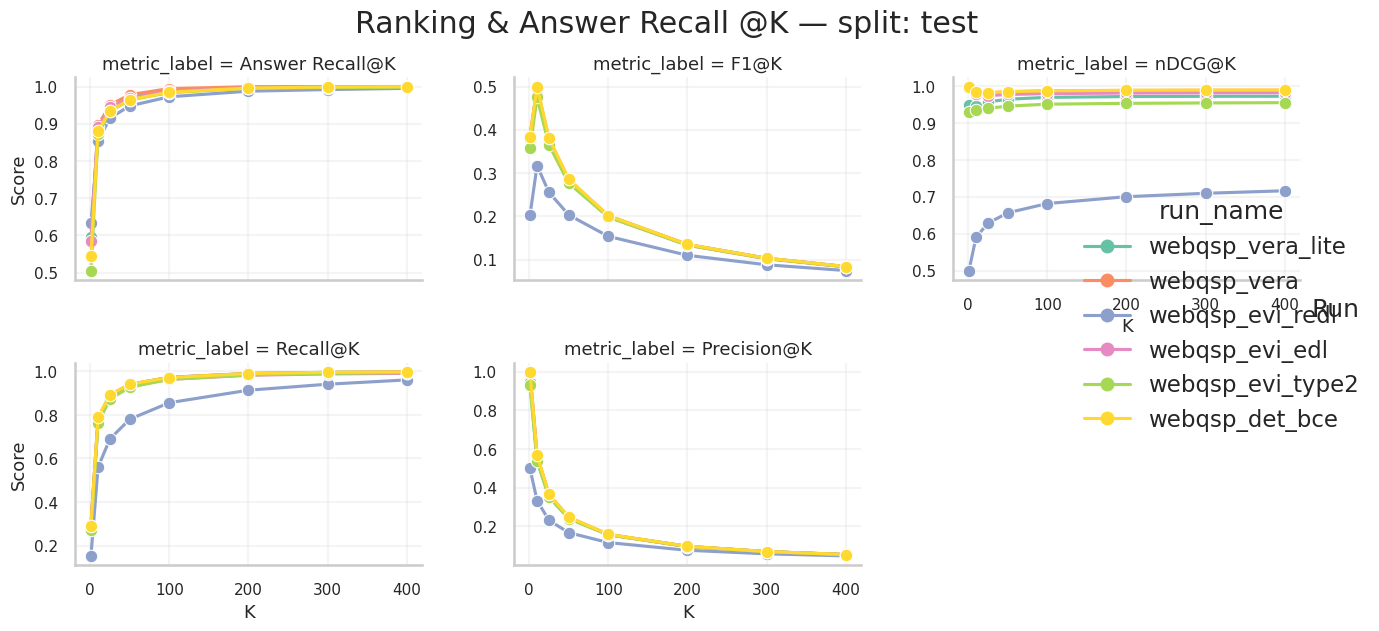

In [54]:
# Ranking @K curves
ranking = tables["ranking_metrics"]
selected_metrics = ["precision", "recall", "f1", "ndcg", "answer_recall"]
if ranking.empty:
    print("No ranking metrics available.")
else:
    ranking = ranking[ranking["metric"].isin(selected_metrics)].copy()
    if ranking.empty:
        print("Selected metrics not found.")
    else:
        ranking = latest_rows(ranking, ("run_name", "metric", "k"))
        ranking = set_run_order(ranking, run_names)
        ranking["metric_label"] = ranking["metric"].apply(pretty_metric_label)

        g = sns.relplot(
            data=ranking,
            x="k",
            y="value",
            hue="run_name",
            col="metric_label",
            col_wrap=3,
            kind="line",
            marker="o",
            palette=run_palette,
            facet_kws={"sharey": False},
            height=3.1,
            aspect=1.15,
        )
        g.set_axis_labels("K", "Score")
        for ax in g.axes.flat:
            ax.grid(alpha=0.2)
        g.add_legend(title="Run")
        g.fig.suptitle(f"Ranking & Answer Recall @K — split: {cfg.split}", y=1.03)
        plt.show()

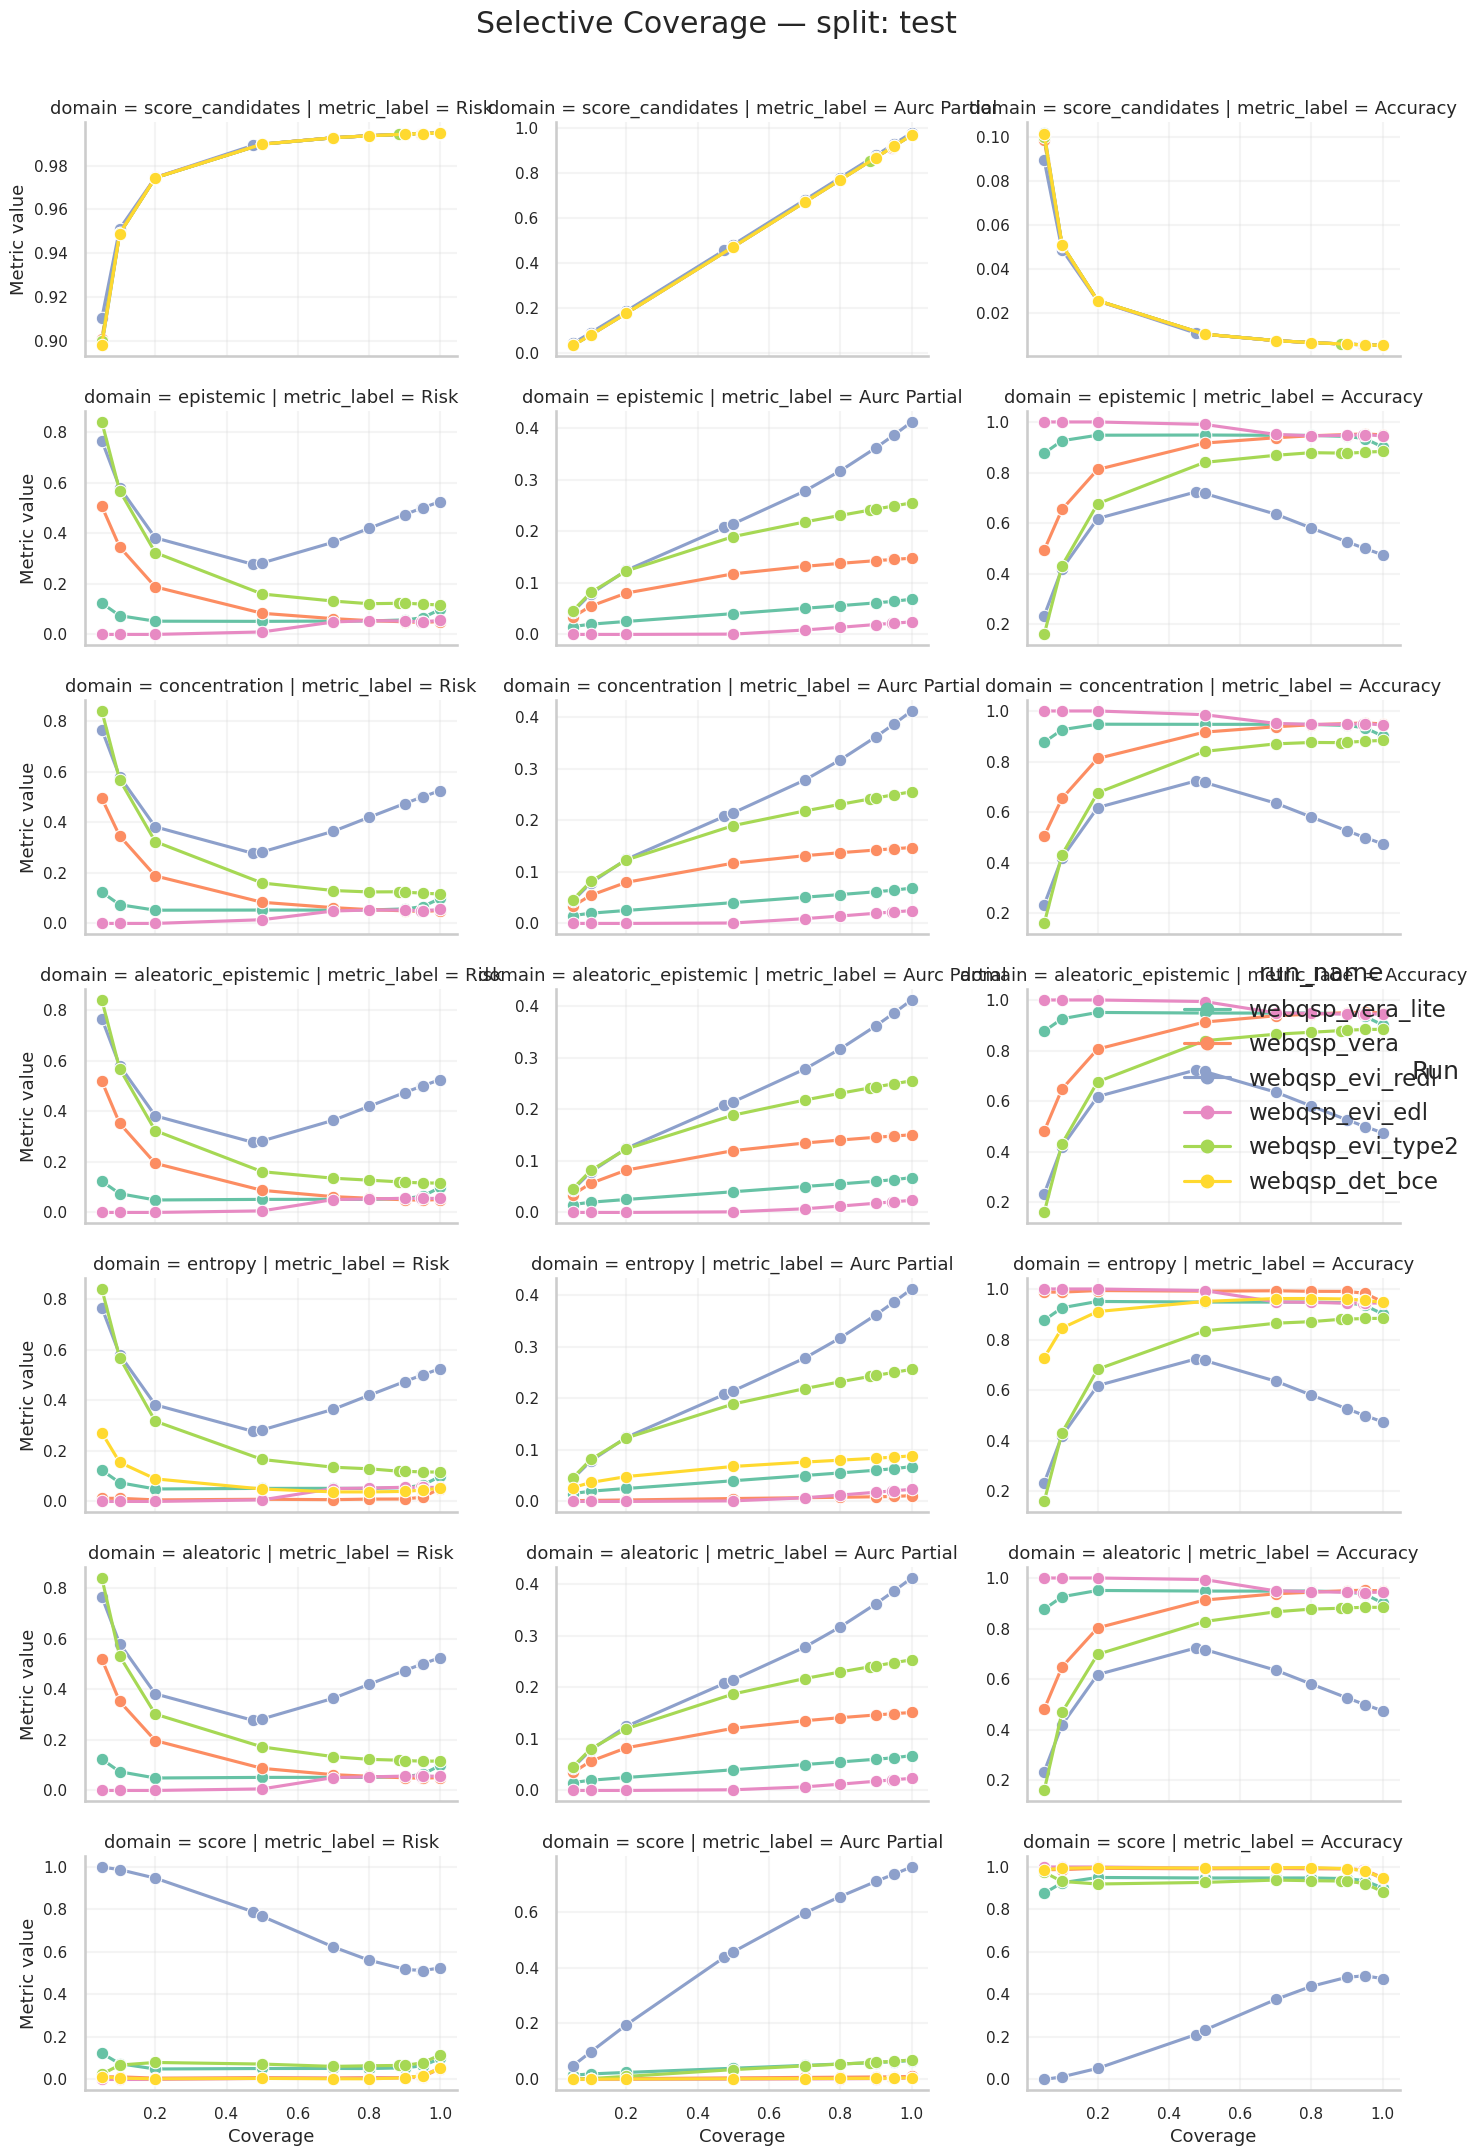

In [55]:
# Selective coverage curves
selective = tables["selective_metrics"]
sel_cov = selective.dropna(subset=["coverage"]).copy()
if sel_cov.empty:
    print("No selective coverage metrics.")
else:
    sel_cov = latest_rows(sel_cov, ("run_name", "domain", "metric", "coverage"))
    sel_cov = sel_cov[sel_cov["domain"].isin(cfg.selective_domains)]
    sel_cov = set_run_order(sel_cov, run_names)
    sel_cov["metric_label"] = sel_cov["metric"].apply(pretty_metric_label)

    g = sns.relplot(
        data=sel_cov,
        x="coverage",
        y="value",
        hue="run_name",
        row="domain",
        col="metric_label",
        kind="line",
        marker="o",
        palette=run_palette,
        facet_kws={"sharex": True, "sharey": False},
        height=3.0,
        aspect=1.3,
    )
    g.set_axis_labels("Coverage", "Metric value")
    for ax in g.axes.flat:
        ax.grid(alpha=0.2)
    g.add_legend(title="Run")
    g.fig.suptitle(f"Selective Coverage — split: {cfg.split}", y=1.03)
    plt.show()

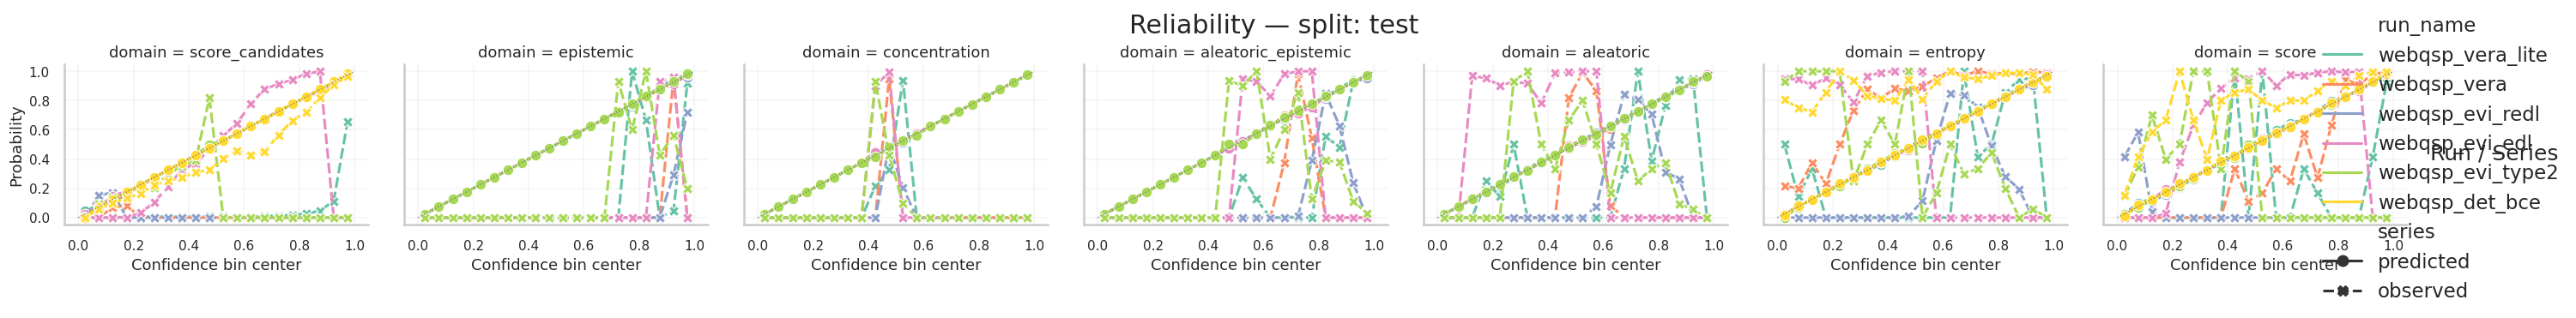

In [56]:
# Reliability diagrams (predicted vs observed)
reliability = tables["reliability_bins"]
if reliability.empty:
    print("No reliability data.")
else:
    reliability = latest_rows(reliability, ("run_name", "domain", "bin_center"))
    reliability = reliability[reliability["domain"].isin(cfg.selective_domains)]
    reliability = set_run_order(reliability, run_names)
    melted = reliability.melt(
        id_vars=["run_name", "domain", "bin_center"],
        value_vars=["predicted", "observed"],
        var_name="series",
        value_name="probability",
    )

    g = sns.relplot(
        data=melted,
        x="bin_center",
        y="probability",
        hue="run_name",
        style="series",
        markers=True,
        kind="line",
        col="domain",
        palette=run_palette,
        facet_kws={"sharex": True, "sharey": True},
        height=3.2,
        aspect=1.15,
    )
    g.set_axis_labels("Confidence bin center", "Probability")
    for ax in g.axes.flat:
        ax.plot([0, 1], [0, 1], linestyle=":", color="gray", linewidth=1)
    g.add_legend(title="Run / Series")
    g.fig.suptitle(f"Reliability — split: {cfg.split}", y=1.03)
    plt.show()